In [1]:
from matplotlib import pyplot as plt
from afinn import Afinn
import numpy as np
afinn = Afinn()
%matplotlib inline

In [2]:
import pandas as pd
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
from gutenberg.query import get_etexts
from gutenberg.query import get_metadata


In [3]:
BOOK_ID = 766
CHAPTER_RE = '^CHAPTER [0-9]*\.'

In [4]:
book_text = strip_headers(load_etext(BOOK_ID, mirror = 'http://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg/')).strip()

In [5]:
#print(book_text)

In [6]:
import re
book_lines = book_text.splitlines()
lines_df = pd.DataFrame({
    "content": book_lines,
    "line": list(range(len(book_lines)))
})
lines_df.head(n=70)


,content,line
0,DAVID COPPERFIELD,0
1,,1
2,,2
3,By Charles Dickens,3
4,,4
...,...,...
65,LI. The Beginning of a Longer Journey,65
66,LII. I Assist at an Explosion,66
67,LIII. Another Retrospect,67
68,LIV. Mr. Micawber’s Transactions,68


In [7]:
print(afinn.score(book_text))

7733.0


In [8]:
def get_chapter_for_lines(dataframe):
    chapters = []
    curr_chapter = 0
    for index, row in dataframe.iterrows():
        if re.search(CHAPTER_RE, row['content'], re.IGNORECASE):
            curr_chapter += 1
        chapters.append(curr_chapter)
        
    return chapters

In [9]:
chapters = get_chapter_for_lines(lines_df)


In [10]:
lines_df['chapter'] = chapters

In [11]:
#sense_sensibility_df.shape

In [12]:
#afinn.score(str(list(book_df[book_df.chapter==24]['content'])))

In [13]:
#import nltk
#nltk.download('punkt')
from tidytext import unnest_tokens
words_df = (unnest_tokens(lines_df, "word", "content"))
words_df = words_df.reset_index()
words_df = words_df.drop(columns=['index'])
words_df = words_df[words_df.word.notnull()]
words_df = words_df.reset_index()
words_df = words_df.drop(columns=['index'])
words_df

C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

,line,chapter,word
0,0,0,david
1,0,0,copperfield
2,3,0,by
3,3,0,charles
4,3,0,dickens
...,...,...,...
380081,38190,64,thee
380082,38190,64,near
380083,38190,64,me
380084,38190,64,pointing


In [14]:
def sign(number):
    return -1 if number < 0 else 1
word_scores = [afinn.score(word) for word in words_df['word']]
word_squared = [sign(afinn.score(word)) * afinn.score(word) * afinn.score(word) for word in words_df['word']]

In [15]:
words_df['word_score'] = word_scores
words_df['word_score_squared'] = word_squared
words_df

,line,chapter,word,word_score,word_score_squared
0,0,0,david,0.0,0.0
1,0,0,copperfield,0.0,0.0
2,3,0,by,0.0,0.0
3,3,0,charles,0.0,0.0
4,3,0,dickens,0.0,0.0
...,...,...,...,...,...
380081,38190,64,thee,0.0,0.0
380082,38190,64,near,0.0,0.0
380083,38190,64,me,0.0,0.0
380084,38190,64,pointing,0.0,0.0


In [16]:
from siuba import *
grouped_book = group_by(words_df, 'chapter')
summarized_book = summarize(grouped_book, chapter_score = _.word_score.sum())
summarized_book

,chapter,chapter_score
0,0,53.0
1,1,-78.0
2,2,156.0
3,3,135.0
4,4,-170.0
...,...,...
60,60,162.0
61,61,171.0
62,62,120.0
63,63,142.0


C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


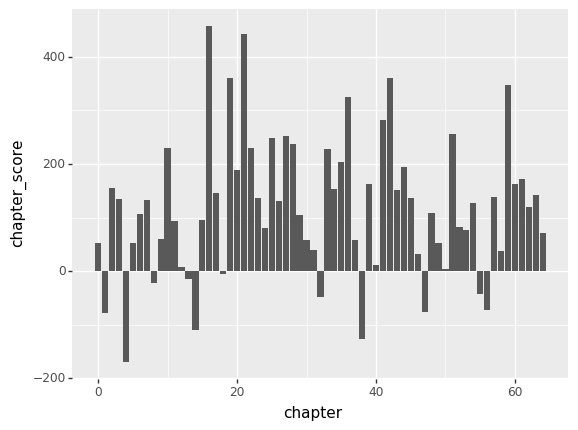

<ggplot: (-9223371882693820876)>

In [17]:
import pandas as pd
from plotnine import *

(ggplot(summarized_book)         # defining what data to use
 + aes(x='chapter', y='chapter_score')    # defining what variable to use
 + geom_bar(stat='identity') # defining the type of plot to use
)

In [18]:
summarized_book_positive = summarize(filter(grouped_book, _.word_score >= 0), chapter_score = _.word_score.sum())
summarized_book_negative = summarize(filter(grouped_book, _.word_score <= 0), chapter_score = _.word_score.sum())


In [19]:
#(ggplot(summarized_book_positive)         # defining what data to use
# + aes(x='chapter', y='chapter_score')    # defining what variable to use
# + geom_bar(stat='identity') # defining the type of plot to use
#)

In [20]:
#(ggplot(summarized_book_negative)         # defining what data to use
# + aes(x='chapter', y='chapter_score')    # defining what variable to use
# + geom_bar(stat='identity') # defining the type of plot to use
#)

In [21]:
summarized_book_positive.head(10)

,chapter,chapter_score
0,0,89.0
1,1,250.0
2,2,365.0
3,3,389.0
4,4,435.0
5,5,362.0
6,6,220.0
7,7,476.0
8,8,375.0
9,9,276.0


In [22]:
from nrclex import NRCLex
text_object = NRCLex(book_text)
#text_object.lexicon


In [23]:
text_object.top_emotions

[('positive', 0.23057556847095376)]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

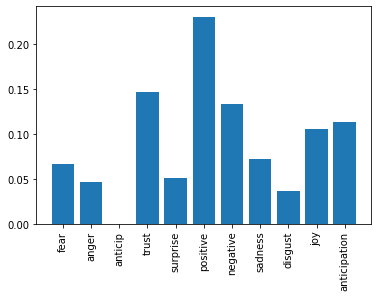

In [24]:
D = text_object.affect_frequencies
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.xticks(rotation = 90)

In [25]:
list_sentiments = [NRCLex(elem).top_emotions for elem in words_df['word']]
#print(list_sentiments[100])

In [26]:
sentiments = [elem[0] for elem in list_sentiments]
sentiments_words_df = words_df.assign(sentiment = sentiments)
sentiments_words_df.head()

,line,chapter,word,word_score,word_score_squared,sentiment
0,0,0,david,0.0,0.0,"(fear, 0.0)"
1,0,0,copperfield,0.0,0.0,"(fear, 0.0)"
2,3,0,by,0.0,0.0,"(fear, 0.0)"
3,3,0,charles,0.0,0.0,"(fear, 0.0)"
4,3,0,dickens,0.0,0.0,"(fear, 0.0)"


In [27]:
sentiments_words_df = sentiments_words_df[sentiments_words_df.apply(lambda row: row['sentiment'][1] > 0.0, axis = 1)]
sentiments_words_df

,line,chapter,word,word_score,word_score_squared,sentiment
30,17,0,change,0.0,0.0,"(fear, 1.0)"
33,18,0,fall,0.0,0.0,"(negative, 0.5)"
35,18,0,disgrace,-2.0,-4.0,"(anger, 0.25)"
62,22,0,happy,3.0,9.0,"(trust, 0.25)"
68,23,0,memorable,1.0,1.0,"(trust, 0.25)"
...,...,...,...,...,...,...
380007,38181,64,remains,0.0,0.0,"(fear, 0.2)"
380017,38183,64,beautiful,3.0,9.0,"(positive, 0.5)"
380018,38183,64,serenity,0.0,0.0,"(trust, 0.25)"
380035,38185,64,dear,2.0,4.0,"(positive, 1.0)"


In [28]:
test_per_chapter = words_df.groupby('chapter').agg({'line':'first', 
                             'word': ', '.join, 
                             'word_score':'sum' }).reset_index()

In [29]:
test_per_chapter

,chapter,line,word,word_score
0,0,0,"david, copperfield, by, charles, dickens, affe...",53.0
1,1,160,"chapter, 1, i, am, born, whether, i, shall, tu...",-78.0
2,2,681,"chapter, 2, i, observe, the, first, objects, t...",156.0
3,3,1315,"chapter, 3, i, have, a, change, the, carrier, ...",135.0
4,4,2005,"chapter, 4, i, fall, into, disgrace, if, the, ...",-170.0
...,...,...,...,...
60,60,36317,"chapter, 60, agnes, my, aunt, and, i, when, we...",162.0
61,61,36726,"chapter, 61, i, am, shown, two, interesting, p...",171.0
62,62,37266,"chapter, 62, a, light, shines, on, my, way, th...",120.0
63,63,37669,"chapter, 63, a, visitor, what, i, have, purpos...",142.0


In [30]:
def plot_emotion(emotion):
    my_emotion_list = [NRCLex(elem).raw_emotion_scores[emotion] if emotion in NRCLex(elem).raw_emotion_scores else 0 for elem in test_per_chapter['word']]
    plt.plot(my_emotion_list)
    plt.xlabel('Chapter')
    plt.ylabel(f'{emotion} occurrences')


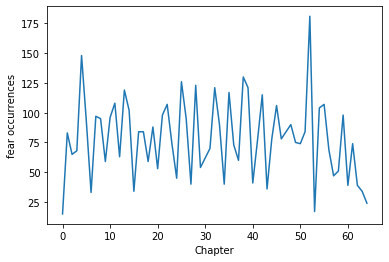

In [31]:
plot_emotion('fear')

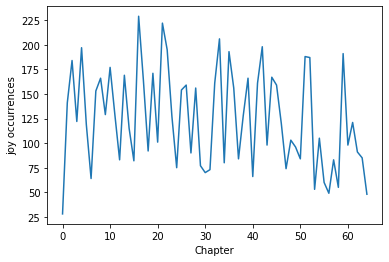

In [32]:
plot_emotion('joy')

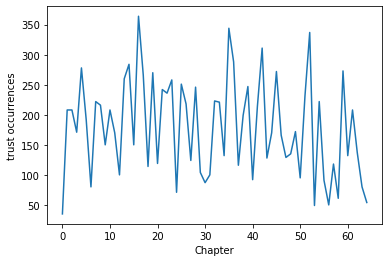

In [33]:
plot_emotion('trust')

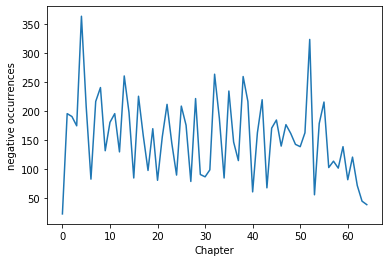

In [34]:
plot_emotion('negative')

In [35]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
scores = sia.polarity_scores('Yay')
scores


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5267}

In [36]:
list_nltk_sentiments = ['positive' if sia.polarity_scores(word)['compound'] > 0 else 'negative' if sia.polarity_scores(word)['compound'] < 0 else 'neutral' for word in sentiments_words_df['word']]


In [37]:
list_nltk_compound = [sia.polarity_scores(word)['compound'] for word in sentiments_words_df['word']]

In [38]:
sentiments_words_df['nltk_sentiment'] = list_nltk_sentiments
sentiments_words_df['nltk_compound_score'] = list_nltk_compound
sentiments_words_df

,line,chapter,word,word_score,word_score_squared,sentiment,nltk_sentiment,nltk_compound_score
30,17,0,change,0.0,0.0,"(fear, 1.0)",neutral,0.0000
33,18,0,fall,0.0,0.0,"(negative, 0.5)",neutral,0.0000
35,18,0,disgrace,-2.0,-4.0,"(anger, 0.25)",negative,-0.4939
62,22,0,happy,3.0,9.0,"(trust, 0.25)",positive,0.5719
68,23,0,memorable,1.0,1.0,"(trust, 0.25)",neutral,0.0000
...,...,...,...,...,...,...,...,...
380007,38181,64,remains,0.0,0.0,"(fear, 0.2)",neutral,0.0000
380017,38183,64,beautiful,3.0,9.0,"(positive, 0.5)",positive,0.5994
380018,38183,64,serenity,0.0,0.0,"(trust, 0.25)",neutral,0.0000
380035,38185,64,dear,2.0,4.0,"(positive, 1.0)",positive,0.3818


In [39]:
chapter_scores_nltk = sentiments_words_df.groupby('chapter').agg({'nltk_compound_score' : 'sum'})
chapter_scores_afinn = sentiments_words_df.groupby('chapter').agg({'word_score' : 'sum'})
chapter_scores_afinn_squared = sentiments_words_df.groupby('chapter').agg({'word_score_squared' : 'sum'})
chapters_df = count(filter(sentiments_words_df, _.nltk_sentiment != 'neutral'), 'chapter', 'nltk_sentiment')
#chapters_df

In [40]:
chapters_df.loc[chapters_df['nltk_sentiment'] == 'negative', 'n'] *= -1
#chapters_df

In [41]:
chapters_df_sentiment = chapters_df.groupby('chapter').agg({'n':'sum'})
chapters_df_sentiment.reset_index()
chapters_df_sentiment['nltk_score'] = chapter_scores_nltk
chapters_df_sentiment['afinn_score'] = chapter_scores_afinn
chapters_df_sentiment['afinn_score_squared'] = chapter_scores_afinn_squared
chapters_df_sentiment

,n,nltk_score,afinn_score,afinn_score_squared
chapter,,,,
0,9,4.7913,27.0,73.0
1,-14,-3.6872,0.0,48.0
2,48,25.9571,95.0,259.0
3,26,15.3201,57.0,173.0
4,-18,-10.8935,-75.0,-155.0
...,...,...,...,...
60,47,26.5499,137.0,385.0
61,46,19.8182,70.0,152.0
62,52,24.6873,104.0,282.0


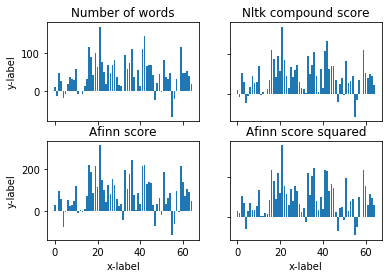

In [42]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(chapters_df_sentiment.index, chapters_df_sentiment['n'])
axs[0, 0].set_title('Number of words')
axs[0, 1].bar(chapters_df_sentiment.index, chapters_df_sentiment['nltk_score'])
axs[0, 1].set_title('Nltk compound score')
axs[1, 0].bar(chapters_df_sentiment.index, chapters_df_sentiment['afinn_score'])
axs[1, 0].set_title('Afinn score')
axs[1, 1].bar(chapters_df_sentiment.index, chapters_df_sentiment['afinn_score_squared'])
axs[1, 1].set_title('Afinn score squared')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [43]:
#diff_sign = [not(sign(chapters_df_sentiment.loc[chapter, 'afinn_score']) == sign(chapters_df_sentiment.loc[chapter, 'afinn_score_squared'])) for chapter in chapters_df_sentiment.index]
#chapters_df_sentiment.loc[diff_sign, ['afinn_score', 'afinn_score_squared']]
diff_of_scores = [(abs(chapters_df_sentiment.loc[chapter, 'afinn_score'] - chapters_df_sentiment.loc[chapter, 'afinn_score_squared']), chapter) for chapter in chapters_df_sentiment.index]
diff_of_scores.sort(reverse = True)
top_chapter = diff_of_scores[0][1]
print(f'Top difference chapter: {top_chapter}')
#print(diff_of_scores)
#print(diff_sign)
#afinn_diff_sign_chapters = set(chapters_df_sentiment[diff_sign].index.copy())
#print(afinn_diff_sign_chapters)
diff_sign_chapters_df = sentiments_words_df[sentiments_words_df.apply(lambda row: row['chapter'] == top_chapter, axis = 1)]
print(diff_sign_chapters_df.groupby(['chapter', 'word']).size().sort_values().tail(10))

Top difference chapter: 21
chapter  word       
21       fellow          7
         gent            8
         love            9
         thought        11
         respectable    12
         dear           13
         don            14
         time           15
         sir            19
         good           20
dtype: int64


In [44]:
positive_contribution = (sentiments_words_df
  >> filter(_.nltk_sentiment == 'positive')
  >> count(_.word, sort=True)
).head(10)
positive_contribution

,word,n
0,dear,569
1,good,533
2,love,260
3,friend,214
4,hope,198
5,happy,179
6,pretty,155
7,kind,137
8,glad,129
9,feeling,98


In [45]:
negative_contribution = (sentiments_words_df
  >> filter(_.nltk_sentiment == 'negative')
  >> count(_.word, sort=True)
).head(10)
negative_contribution

,word,n
0,fire,178
1,leave,141
2,doubt,120
3,shaking,92
4,lost,77
5,bad,73
6,grave,58
7,lying,57
8,forget,56
9,cry,49


In [46]:
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
tokenizer.train(book_text)
sentences = tokenizer.tokenize(book_text)
sentences_score = [afinn.score(sentence) for sentence in sentences]

In [47]:
sentences_df = pd.DataFrame({'sentence': sentences, 'sentence_score': sentences_score})
sentences_df

,sentence,sentence_score
0,DAVID COPPERFIELD\r\n\r\n\r\nBy Charles Dicken...,0.0
1,Mr.,0.0
2,AND Mrs.,0.0
3,"RICHARD WATSON,\r\n OF ROCKINGHA...",0.0
4,CONTENTS\r\n\r\n\r\n I. I Am Born\r\n...,0.0
...,...,...
18030,"But one face, shining on me like a Heavenly li...",6.0
18031,And\r\nthat remains.,0.0
18032,"I turn my head, and see it, in its beautiful s...",3.0
18033,"My lamp burns low, and I have written far into...",2.0


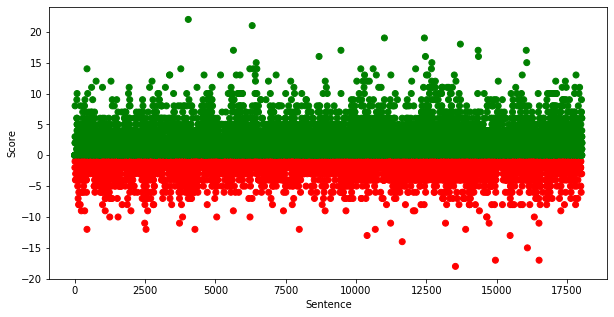

In [48]:
fig = plt.figure(figsize = (10, 5))
colors = np.where(np.array(sentences_score) < 0, 'red', 'green')
plt.scatter(sentences_df.index, sentences_score, c = colors)
plt.xlabel('Sentence')
plt.ylabel('Score')
plt.show()

In [49]:
top_positive_sentences = sentences_df.sort_values(by = 'sentence_score', ascending = False)['sentence'][:10]
for sentence in top_positive_sentences:
    print(sentence + '\n-----\n')

That
Peggotty was the best, the truest, the most faithful, most devoted, and
most self-denying friend and servant in the world; who had ever loved
me dearly, who had ever loved my mother dearly; who had held my mother’s
dying head upon her arm, on whose face my mother had imprinted her last
grateful kiss.
-----

But his easy, spirited good humour; his genial manner, his handsome
looks, his natural gift of adapting himself to whomsoever he pleased,
and making direct, when he cared to do it, to the main point of interest
in anybody’s heart; bound her to him wholly in five minutes.
-----

He was like one under the propitious
influence of a charm, from the moment of his being usefully employed;
and if there were a happy man in the world, that Saturday night, it was
the grateful creature who thought my aunt the most wonderful woman in
existence, and me the most wonderful young man.
-----

Copperfield, that you are a young gentleman
possessed of good qualities and honourable character; or th

In [50]:
top_negative_sentences = sentences_df.sort_values(by = 'sentence_score', ascending = True)['sentence'][:10]
for sentence in top_negative_sentences:
    print(sentence + '\n-----\n')

‘Not a word, boy!’ he pursued in a whisper; ‘leave all the blame with
Dick--simple Dick--mad Dick.
-----

But,
fear of not being forgiv, fear of being pinted at, fear of some of
us being dead along of her, fear of many things, turned her from it,
kiender by force, upon the road: “Uncle, uncle,” she says to me, “the
fear of not being worthy to do what my torn and bleeding breast so
longed to do, was the most fright’ning fear of all!
-----

Moan
for your nurture of him, moan for your corruption of him, moan for your
loss of him, moan for mine!’

She clenched her hand, and trembled through her spare, worn figure, as
if her passion were killing her by inches.
-----

Wickfield, being so weak and
helpless in his hands as to pay you, afterwards, several sums of
interest on a pretended principal which he knew did not exist, made
himself, unhappily, a party to the fraud.’

‘And at last took the blame upon himself,’ added my aunt; ‘and wrote me
a mad letter, charging himself with robbery, and wr

In [51]:
test_per_chapter

,chapter,line,word,word_score
0,0,0,"david, copperfield, by, charles, dickens, affe...",53.0
1,1,160,"chapter, 1, i, am, born, whether, i, shall, tu...",-78.0
2,2,681,"chapter, 2, i, observe, the, first, objects, t...",156.0
3,3,1315,"chapter, 3, i, have, a, change, the, carrier, ...",135.0
4,4,2005,"chapter, 4, i, fall, into, disgrace, if, the, ...",-170.0
...,...,...,...,...
60,60,36317,"chapter, 60, agnes, my, aunt, and, i, when, we...",162.0
61,61,36726,"chapter, 61, i, am, shown, two, interesting, p...",171.0
62,62,37266,"chapter, 62, a, light, shines, on, my, way, th...",120.0
63,63,37669,"chapter, 63, a, visitor, what, i, have, purpos...",142.0


In [52]:
top_positive_chapter = test_per_chapter.sort_values(by = "word_score", ascending = False).iloc[0, 0]
#print(str(top_positive_chapter))

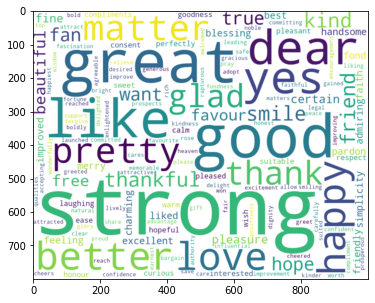

In [53]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
positive_words = dict(filter(filter(words_df, _.chapter == top_positive_chapter), _.word_score > 0.0)['word'].value_counts())
#print(positive_words)
wordcloud = WordCloud(background_color='white', width=1000, height=800).generate_from_frequencies(positive_words)
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()


In [54]:
top_negative_chapter = test_per_chapter.sort_values(by = "word_score", ascending = True).iloc[0, 0]
#print(str(top_negative_chapter))
words_df

,line,chapter,word,word_score,word_score_squared
0,0,0,david,0.0,0.0
1,0,0,copperfield,0.0,0.0
2,3,0,by,0.0,0.0
3,3,0,charles,0.0,0.0
4,3,0,dickens,0.0,0.0
...,...,...,...,...,...
380081,38190,64,thee,0.0,0.0
380082,38190,64,near,0.0,0.0
380083,38190,64,me,0.0,0.0
380084,38190,64,pointing,0.0,0.0


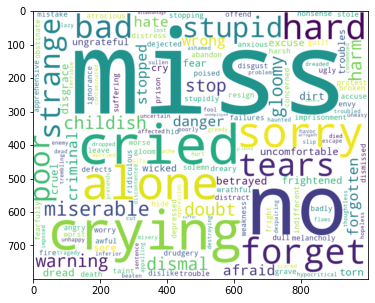

In [55]:
negative_words = dict(filter(filter(words_df, _.chapter == top_negative_chapter), _.word_score < 0.0)['word'].value_counts())
#print(negative_words)
wordcloud = WordCloud(background_color='white', width=1000, height=800).generate_from_frequencies(negative_words)
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()
